---
# **Predicción sobre la demanda en el servicio Bicing**
---




## **Introducción**

El objetivo de este notebook realizado por **Fernando Guirao** y **Nicolás Llorens** es exponer el tema a tratar en el proyecto de la asignatura de APA (Q1 23-24). En este proyecto debe escogerse un conjunto de datos sobre el que reolver un problema de regresión o un problema de clasificación. A continuación explicaremos el problema que queremos resolver, qué datos hemos obtenido y cómo los hemos obtenido, además de un análisis preliminar de los mismos.

## **¿Qué es Bicing?**

**Bicing** es un servicio de alquiler de bicicletas promovido por el Ayuntamiento de Barcelona. Dispone de bicicletas mecánicas y eléctricas que pueden ser recogidas y dejadas en las diferentes estaciones que hay repartidas por la ciudad.

## **Motivación**


Muchos estudiantes del Campus Nord usan este servicio para ir y volver de la universidad, pero la alta demanda hace que las estaciones aledañas a menudo queden vacías obligando a muchos a escoger transportes alternativos.

Naturalmente el servicio cuenta con remolcadores que reponen bicicletas en las estaciones que se quedan vacías a ciertas horas del día. Pero a veces, quizás esto no es suficiente.

Nuestra idea inicial es realizar predicciones sobre la demanda por cada estación en una determinada hora del día. Esta información puede resultar muy valiosa para que , de forma preventiva, se puedan reponer bicicletas en la estación ante horas donde se espera una alta demanda.

Concretamente trabajaremos sobre los datos de la estación que se encuentra en la **Calle Jordi Girona, 29**, ya que es la estación que se encuentra justo debajo del campus. No obstante la idea es que este modelo pueda aplicarse a cuqluier estación, siempre y cuando sea entrenado con los datos de esta.

## **Obtención de los datos, filtrados y modificaciones**

Los datos sobre los que trabajaremos se encuentran en el catálogo de datasets de **Open Data BCN**. El [dataset original](https://opendata-ajuntament.barcelona.cat/data/ca/dataset/estat-estacions-bicing) recoge información sobre el estado de **todas** las estaciones a cada momento (cada pocos minutos).

Debido al gran tamaño de estos datos (dado que existen más de 500 estaciones), estos se dividen en varios archivos (uno por mes). Estas son las columnas que contiene cada archivo:

- **`last_updated`**: Timestamp del archivo.
- **`ttl`**: Tiempo de vida de la respuesta.
- **`data`**: Contenedor de arrays de información de estaciones.
- **`station`**: Array de datos de cada estación.
- **`station_id`**: Identificador de la estación.
- **`num_bikes_available`**: Número de bicicletas disponibles.
- **`num_bikes_available_types`**: Array de tipos de bicicletas disponibles.
- **`mechanical`**: Número de bicicletas mecánicas disponibles.
- **`ebike`**: Número de bicicletas eléctricas disponibles.
- **`num_docks_available`**: Número de anclajes disponibles.
- **`is_installed`**: Si la estación está correctamente instalada (0-NO,1-SÍ).
- **`is_renting`**: Si la estación está proporcionando bicicletas correctamente.
- **`is_returning`**: Si la estación está anclando bicicletas correctamente.
- **`last_reported`**: Timestamp de la información de la estación.
- **`is_charging_station`**: Si la estación tiene capacidad de carga de bicicletas eléctricas.
- **status**: Estado de la estación (IN_SERVICE=En servicio, CLOSED=Cerrada)​​.

### **- Primeros filtrados**

Muchas de las variables del dataset original que hemos mostrado no son relevantes para nuestro estudio. Concretamente, nos quedaremos con las variables que nos proporcionan información sobre la disponibilidad de las bicicletas y el timestamp de esta información, i.e.  `num_bikes_available`,	`num_bikes_available_types.mechanical`, `num_bikes_available_types.ebike`,	`num_docks_available`	y `last_reported`.

Además tampoco contamos con la variable `station_id`, ya que seleccionamos todas aquellas que tienen el identificador de la estación que queremos estudiar, que es la número 422. Esto evidentemente reduce de manera drástica el tamaño de los datos.

Estos primeros filtrados los realizamos con scripts que no incluimos en este notebook ya que son costosos para ser realizados en la herramienta de Google Collab. No obstante estos scripts se incluyen en el repositorio del proyecto y pueden ser enviados al tutor si este lo precisa.

### **- Datos... ¿desde cuándo?**

OpenData BCN ofrece todos los datos del servicio desde la última renovación del mismo en 2019 (existen anteriores pero el servicio era significativamente distinto). No obstante, en principio optaremos por tomar datos de los **últimos dos años**, es decir, desde septiembre de 2021 hasta septiembre de 2023. Hemos preferido no tomar datos anteriores debido a las restricciones de movilidad impuestas por aquel entonces, ya que podrían añadir demasiada complejidad al problema.

Además debemos mencionar que para este breve estudio preliminar hemos tomado datos únicamente del último año por simplicidad. (Somos conscientes de que puede ser una mala práctica pero al momento de redactar este informe ya no tenemos margen para revertirlo).

### **- Obtención de variables temporales**


Hasta el momento la única variable cronológica de la que disponemos es `last_reported`, que indica el timestamp, es decir, el momento en el que la estación recogió la información. Cada timestamp codifica una fecha, por lo que de este número podremos extraer las variables `month`, `monthday`, `weekday`, `hour` y `minute`.

Ahora sí vamos a cargar el dataset del último año con los primeros filtrados anteriores ya realizados, y las variables ya mencionadas también añadidas (insistimos en que estas acciones se ven reflejadas en los scripts).

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

In [24]:
dataset = pd.read_csv("./DataFrame.csv", header=0, delimiter=',')

dataset.sample(5)

,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,month,day_month,day_week,hour,minute
14134,27.0,0.0,27.0,1.0,1.672e+09,12,21,2,11,6
21245,1.0,0.0,1.0,26.0,1.689e+09,7,15,5,2,44
50131,20.0,2.0,18.0,8.0,1.675e+09,1,31,1,13,1
18569,2.0,0.0,2.0,25.0,1.689e+09,7,5,2,19,42
54949,0.0,0.0,0.0,19.0,1.695e+09,9,21,3,18,0


### **- ¿Cómo cuantificar la demanda? ¿Cuál es la variable objetivo?**

Esta parte es crucial para el correcto desarrollo del proyecto. Tenemos que definir una variable que explique la demanda de bicicletas en la estación, ya que el dataset original no la tiene.

Esta es una tarea desafiante y no trivial, puesto que a partir de los datos de los que disponemos, debemos construir una variable que refleje explique lo mejor posible la demanda de bicicletas en la estación.

Tras varios planteamientos y análisis de ciertas situaciones, decidimos expresar la **demanda** de bicicletas en una estación, en una hora determinada como el **número de bicicletas necesarias para satosfacer la demanda en dicha hora**. En otras palabras, el número de bicicletas que debe haber en la estación al principio de la hora de modo que se puedan satisfacer todas las salidas (teniendo en cuenta además las bicicletas que entran).

Para ilustrar esto, vamos a graficar un ejemplo. Concretamente la evolución de bicicletas eléctricas en la estación el 10 de noviembre de 2022 durante las 12 del mediodía:

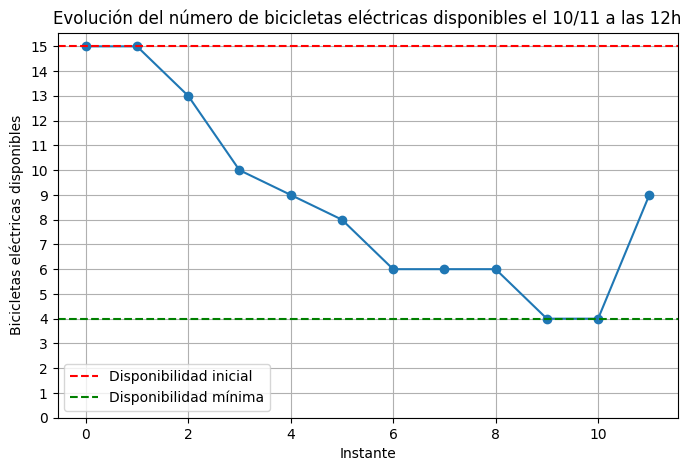

In [9]:
# Secuencia de números
datos = [15.0, 15.0, 13.0, 10.0, 9.0, 8.0, 6.0, 6.0, 6.0, 4.0, 4.0, 9.0]

# Etiquetas
eje_x = "Instante"
eje_y = "Bicicletas eléctricas disponibles"
titulo = "Evolución del número de bicicletas eléctricas disponibles el 10/11 a las 12h"

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(datos, marker='o', linestyle='-')
plt.xlabel(eje_x)
plt.ylabel(eje_y)
plt.title(titulo)

# Configurar el eje Y para mostrar todos los enteros desde 0 hasta el valor máximo
plt.yticks(range(int(max(datos)) + 1))

# Agregar líneas horizontales discontinuas para la disponibilidad inicial y mínima
plt.axhline(y=15, color='r', linestyle='--', label='Disponibilidad inicial')
plt.axhline(y=4, color='g', linestyle='--', label='Disponibilidad mínima')

# Mostrar el gráfico con la leyenda
plt.legend()
plt.grid(True)
plt.show()

Vemos que, si restamos la disponibilidad inicial y la disponibilidad mínima, obtenemos el número 11. Esto es, el número de bicicletas que, como mínimo, debería tener la estación a las 12 en punto para absorber la demanda que se muestra en el gráfico.

Veamos como, partiendo desde 11 bicicletas, la cantidad nunca cae por debajo de 0, es decir, no se realizan salidas imposibles (o sea, no satisfechas).

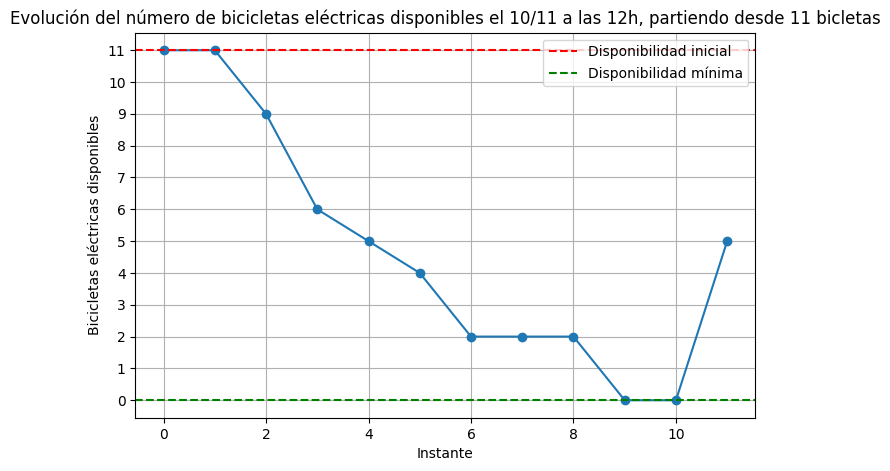

In [12]:
# Secuencia de números
datos = [11.0, 11.0, 9.0, 6.0, 5.0, 4.0, 2.0, 2.0, 2.0, 0.0, 0.0, 5.0]

# Etiquetas
eje_x = "Instante"
eje_y = "Bicicletas eléctricas disponibles"
titulo = "Evolución del número de bicicletas eléctricas disponibles el 10/11 a las 12h, partiendo desde 11 bicicletas"

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(datos, marker='o', linestyle='-')
plt.xlabel(eje_x)
plt.ylabel(eje_y)
plt.title(titulo)

# Configurar el eje Y para mostrar todos los enteros desde 0 hasta el valor máximo
plt.yticks(range(int(max(datos)) + 1))

# Agregar líneas horizontales discontinuas para la disponibilidad inicial y mínima
plt.axhline(y=11, color='r', linestyle='--', label='Disponibilidad inicial')
plt.axhline(y=0, color='g', linestyle='--', label='Disponibilidad mínima')

# Mostrar el gráfico con la leyenda
plt.legend()
plt.grid(True)
plt.show()

Entonces uno puede pensar que el número mínimo de bicicletas necesarias para absorber la demanda en una hora (a partir de ahora `min_required_bikes`) es simplemente la diferencia entre la disponibilidad inicial y la disponibilidad mínima. Pero no es del todo así.

Veamos otro ejemplo, en este caso del 3 de octubre de 2022 durante las 7 de la mañana:

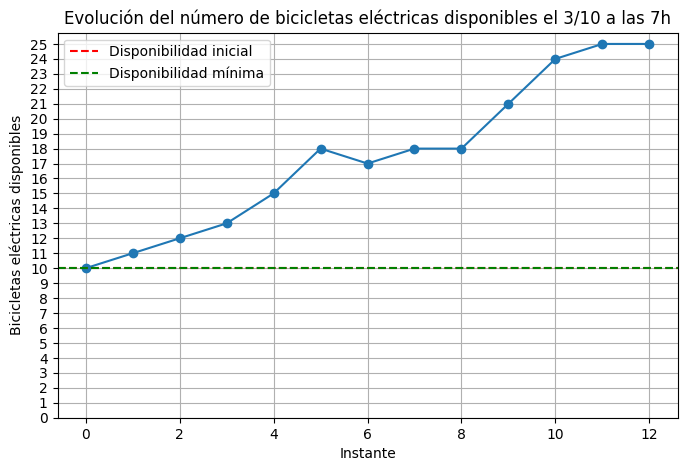

In [10]:
# Secuencia de números
datos = [10.0, 11.0, 12.0, 13.0, 15.0, 18.0, 17.0, 18.0, 18.0, 21.0, 24.0, 25.0, 25.0]

# Etiquetas
eje_x = "Instante"
eje_y = "Bicicletas eléctricas disponibles"
titulo = "Evolución del número de bicicletas eléctricas disponibles el 3/10 a las 7h"

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(datos, marker='o', linestyle='-')
plt.xlabel(eje_x)
plt.ylabel(eje_y)
plt.title(titulo)

# Configurar el eje Y para mostrar todos los enteros desde 0 hasta el valor máximo
plt.yticks(range(int(max(datos)) + 1))

# Agregar líneas horizontales discontinuas para la disponibilidad inicial y mínima
plt.axhline(y=10, color='r', linestyle='--', label='Disponibilidad inicial')
plt.axhline(y=10, color='g', linestyle='--', label='Disponibilidad mínima')

# Mostrar el gráfico con la leyenda
plt.legend()
plt.grid(True)
plt.show()

En este caso disponibilidad inicial y disponibilidad mínima se solapan, lo cuál nos haría pensar que `min_required_bikes` es 0. Veamos que ocurre si empezamos desde 0:

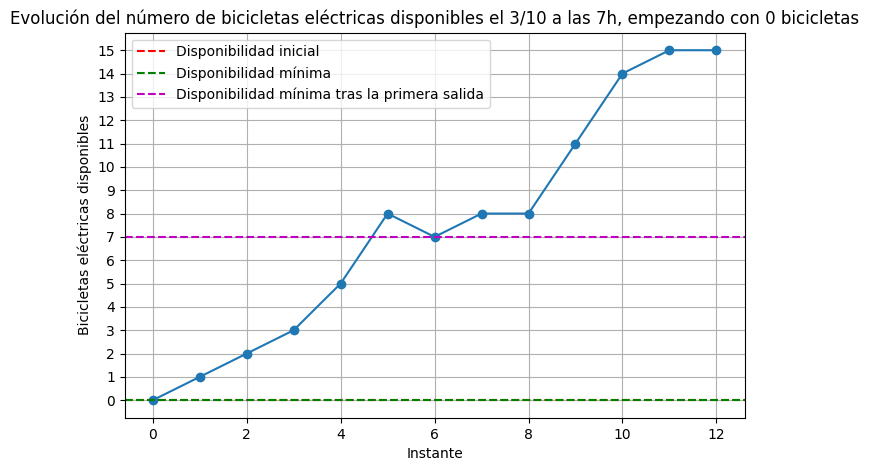

In [17]:
# Secuencia de números
datos = [0.0, 1.0, 2.0, 3.0, 5.0, 8.0, 7.0, 8.0, 8.0, 11.0, 14.0, 15.0, 15.0]

# Etiquetas
eje_x = "Instante"
eje_y = "Bicicletas eléctricas disponibles"
titulo = "Evolución del número de bicicletas eléctricas disponibles el 3/10 a las 7h, empezando con 0 bicicletas"

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(datos, marker='o', linestyle='-')
plt.xlabel(eje_x)
plt.ylabel(eje_y)
plt.title(titulo)

# Configurar el eje Y para mostrar todos los enteros desde 0 hasta el valor máximo
plt.yticks(range(int(max(datos)) + 1))

# Agregar líneas horizontales discontinuas para la disponibilidad inicial y mínima
plt.axhline(y=0, color='r', linestyle='--', label='Disponibilidad inicial')
plt.axhline(y=0, color='g', linestyle='--', label='Disponibilidad mínima')
plt.axhline(y=7, color='m', linestyle='--', label='Disponibilidad mínima tras la primera salida')

# Mostrar el gráfico con la leyenda
plt.legend()
plt.grid(True)
plt.show()

Efectivamente, la demanda se satisface, pero, ¿podemos hacerlo mejor?. Sí, de hecho al principio, llegan muchas bicicletas que luego no salen, es decir, **sobran** para satisfacer la demanda.

En este gráfico, hemos indicado a propósito la **disponibilidad mínima tras la primera salida**, esto es, la disponibilidad mínima que alcanza la estación tras las entrada consecutivas que se producen al principio.

Hagamos ahora la diferencia entre la disponibilidad inicial, y la disponibiidas mínima tras la primera salida. Obtenemos un número negativo, el -7. Parece no tener mucho sentido partir de -7 bicicletas, pero grafiquémoslo igualmente:

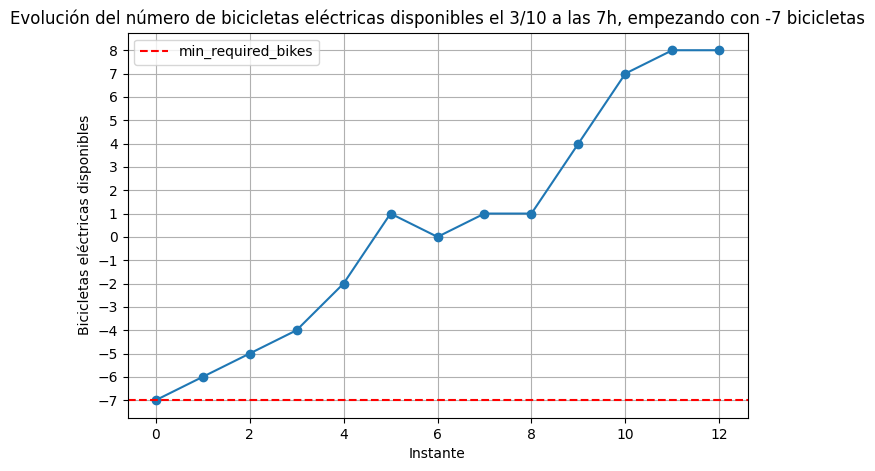

In [22]:
# Secuencia de números
datos = [-7.0, -6.0, -5.0, -4.0, -2.0, 1.0, 0.0, 1.0, 1.0, 4.0, 7.0, 8.0, 8.0]

# Etiquetas
eje_x = "Instante"
eje_y = "Bicicletas eléctricas disponibles"
titulo = "Evolución del número de bicicletas eléctricas disponibles el 3/10 a las 7h, empezando con -7 bicicletas"

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(datos, marker='o', linestyle='-')
plt.xlabel(eje_x)
plt.ylabel(eje_y)
plt.title(titulo)

# Calcular los límites del rango para el eje Y
min_y = int(min(datos))
max_y = int(max(datos))

# Configurar el eje Y para mostrar todos los enteros en el rango entre min_y y max_y
plt.yticks(range(min_y, max_y + 1))

# Agregar líneas horizontales discontinuas para la disponibilidad inicial y mínima
plt.axhline(y=-7, color='r', linestyle='--', label='min_required_bikes?')

# Mostrar el gráfico con la leyenda
plt.legend()
plt.grid(True)
plt.show()

La forma de interpetar esto, es que si calculamos `min_required_bikes` como la diferencia entre la disponibilidad inicial y la disponibilidad mínima tras la primera salida, tenemos que `min_required_bikes` toma valores negativos cuando esa estación no sólo no necesita que se repongan bicicletas, sino le sobran bicicletas para satisfacer la demanda. Esto significa que, haciendo el valor absoluto de este valor negativo, obtendríamos el número de bicicletas que podemos retirar de esa estación sin miedo a que la demanda no se vea satisfecha en esa hora. Para este caso particular, quizás la variable debería ser referida como el **máximo número de bicicletas que sobran para satisfacer la demanda**.

De hecho, lo que vamos a hacer, es que en estos casos `min_required_bikes` tomará como valor 0, puesto no hay que reponer bicicletas, y daremos el valor absoluto del número negativo a una nueva variable `max_surplus_bikes`, que reflejará el excedente de bicicletas que pueden ser recolocadas en otras estaciones.

### **- Pero... ¿Cuál será la variable objetivo?**

Bien, como decíamos antes, en este proyecto queremos estudiar los datos de la estación que se sitúa debajo de la universidad. El problema que observamos en esta estación es un problema de falta de bicicletas, por lo que centraremos nuestro estudio en la variable **`min_required_bikes`**.



### **- ¿Sirven todos los datos?**

Estamos buscando reflejar la demanda real en la estación en una hora determinada. Esto implica que debemos eliminar los registros de aquellas horas donde la demanda no se satisfaga.

La interpretación de que en una hora no se ha satisfecho la demanda no es única. Podemos considerar que esto sucede cuando durante un número determinado de instantes consecutivos, la cantidad de bicicletas disponibles es 0, por lo que **quizás estamos dejando de capturar salidas**.

Podemos añadir complejidad a esta idea considerando que, por ejemplo, durante las horas de clase consideraremos horas en las que no se ha satisfecho la demanda aquellas en las que el nivel de bicicletas ha sido 0 en algún instante, y que durante la madrugada, la demanda no se satisface si esto ocurre durante 5 instantes consecutivos.

Esta última idea en principio la dejamos para más adelante. Ahora, por simplicidad, consideramos la opción más restrictiva.

### **- Una última consideración... ¿Qué ocurre con los excedentes?**

Cuando se producen excdentes, es porque un remolcador ha llenado la estación, o han llegado muchas bicicletas. Para un cálculo real de los excdentes, sería conveniente suprimir aquellas horas en las que la estación no se llena, ya que sino quizás estaríamos dejando de capturar llegadas (esto es análogo a lo que ocurre con la cantidad mínima de bicicletas y el hecho de que la estación quede vacía).

Sin embargo, en principio esta nueva reducción del dataset no la llevaremos a cabo, ya que queremos centrarnos en la demanda de bicicletas. Por lo que seguramente terminemos ignorando `max_surplus_bikes`.

Esto no significa que, con más tiempo y recursos, no sea interesante estudiar los excedentes. De hecho hay otra variable a considerar, que sería el número de plazas disponibles para satisfacer todas las llegadas en una hora.

Probablemente la combinación de demanda de bicicletas, excdentes de biciletas, y demanda de plazas libres sería la opción más potente, si esto se aplicase a todas las estaciones de la ciudad, de modo que se obtendrían unos insights valiosos para redistribuir las bicicletas por la ciudad garantizando el mejor servicio posible. Pero como decimos, este proyecto, en el marco de la asignatura de APA, en principio abarcará hasta la predicción de demanda en una estación determinada. Sin embargo, no descartamos ampliar el proyecto en el futuro.

### **- Replanteamiento***

Durante el redactado de este informe hemos tenido muchas dudas a la hora de esocger la variable que determine la demanda. La variable `min_required_bikes` puede no ser un indicador del todo fiable. Esta cuantifica las bicicletas necesarias para absorber correctamente el flujo que tiene una estación durante una hora concrecta. Pero desconocemos si parte de ese flujo es producido por los remolcadores.

Al final lo más simple es tomar la variable directamente de salidas para ver cuántas bicicletas se cogen. Pero aún así, algunas de esas salidas pueden ser producidas por los remolcadores. Para reducir el efecto de esto, sería bueno conocer a qué horas se retiran y se reponen bicicletas en la parada que queremos estudiar, sin embargo no hemos encontrado esa información. No obstante nos hemos puesto en contacto con Barcelona Serveis Municipals para tratar de obtener la información.

## **Un primer análisis de los datos**

De momento, observaremos las variables de salidas totales y `min_requiered_bikes`. Pero antes que nada, para ello debemos transformar el dataset original. A continuación cargamos directamente el dataset ya transformado, al que además hemos añadido las variables meteorlógicas `temperature`, `rain` y `windspeed`. También cabe mencionar la variable `satisfy_demand` que evalúa falso si en algún momento la estación ha quedado vacía.

In [34]:
bicing = pd.read_csv("./DataFramePerHourAndMeteo.csv", header=0, delimiter=',')

bicing.head()

,min_required_ebike,min_required_mechanical,total_salidas,salidas_electricas,salidas_mecanicas,total_entradas,entradas_electricas,entradas_mecanicas,hour,day_week,day_month,month,satisfy_demand,working_day,temperature,rain,windspeed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,4,30,9,False,1,23.2,0.0,3.8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,4,30,9,False,1,22.8,0.0,2.4
2,1.0,9.0,0.0,0.0,0.0,17.0,3.0,14.0,23,5,1,10,True,1,17.9,0.0,7.6
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,5,1,10,True,1,17.0,0.0,5.7
4,3.0,0.0,4.0,3.0,1.0,1.0,0.0,1.0,1,5,1,10,True,1,17.7,0.0,5.7


Como mencionábamos anteriormente, eliminamos aquellas filas en las que consideramos que no se ha satisfacido la demanda.

In [35]:
bicing = bicing[bicing['satisfy_demand'] == True]

Echemos un vistazo a la estadística descriptiva:

In [36]:
bicing.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
min_required_ebike,5367.0,NaN,NaN,NaN,2.403,4.178,0.0,0.0,1.0,3.0,28.0
min_required_mechanical,5367.0,NaN,NaN,NaN,0.331,1.087,0.0,0.0,0.0,0.0,14.0
total_salidas,5367.0,NaN,NaN,NaN,2.677,3.917,0.0,0.0,1.0,4.0,30.0
salidas_electricas,5367.0,NaN,NaN,NaN,2.352,3.607,0.0,0.0,1.0,3.0,27.0
salidas_mecanicas,5367.0,NaN,NaN,NaN,0.325,0.868,0.0,0.0,0.0,0.0,14.0
total_entradas,5367.0,NaN,NaN,NaN,2.662,3.93,0.0,0.0,1.0,3.0,28.0
entradas_electricas,5367.0,NaN,NaN,NaN,2.421,3.656,0.0,0.0,1.0,3.0,27.0
entradas_mecanicas,5367.0,NaN,NaN,NaN,0.241,0.856,0.0,0.0,0.0,0.0,18.0
hour,5367.0,NaN,NaN,NaN,9.99,6.246,0.0,5.0,9.0,14.0,23.0
day_week,5367.0,NaN,NaN,NaN,3.105,2.057,0.0,1.0,3.0,5.0,6.0


Aquí, lo que principalmente podemos ver, es que el flujo de bicicletas eléctricas es notablemente mayor que el de bicicletas mecánicas. Esto es algo normal, ya que el objetivo principal de estos desplazamientos no es hacer deporte, sino llegar a casa o a la universidad rápida y cómodamente. Por ello, nos centraremos en las variables referentes a las bicicletas eléctricas.

A continuación graficamos histogramas y boxplots para las variables numéricas.

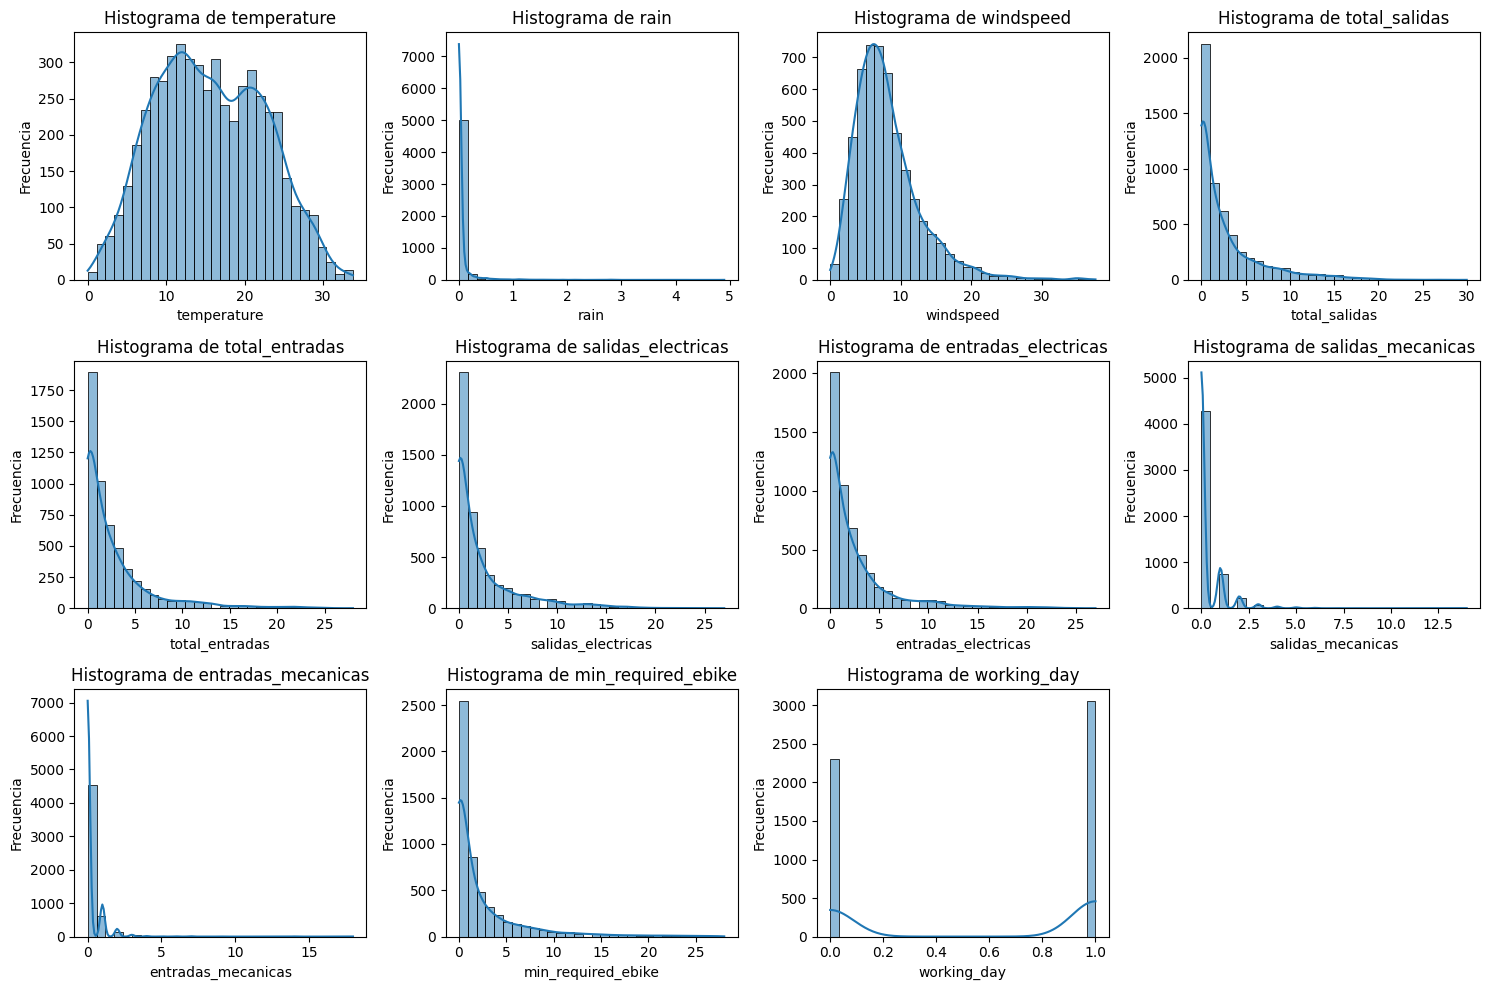

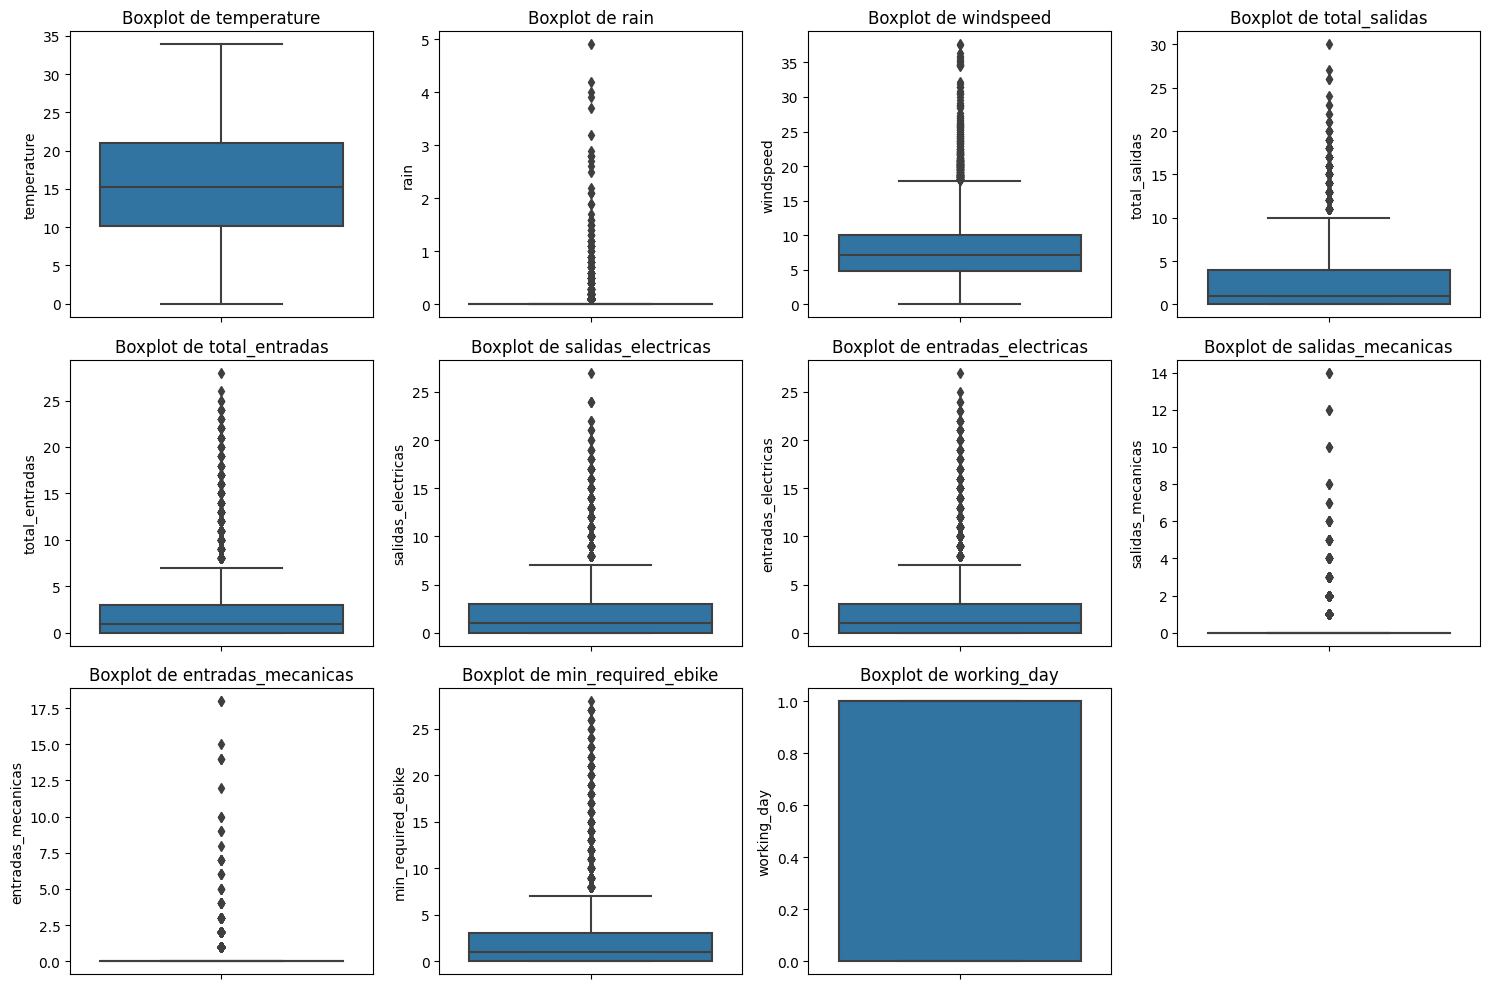

In [37]:
# Lista de variables numéricas
numeric_vars = ["temperature", "rain", "windspeed", "total_salidas", "total_entradas", "salidas_electricas", "entradas_electricas", "salidas_mecanicas", "entradas_mecanicas", "min_required_ebike"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(bicing[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Visualización de boxplots para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=bicing[var])
    plt.title(f'Boxplot de {var}')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

Vemos que las variables relacionadas con el uso de bicicletas muestran sesgos a la derecha. Esto es porque naturalmente no tenemos cantidades de salidas negativas, y, en muchos casos vemos que también estas cantidades de salida son 0, lo cual no debe extrañarnos ya que la mayoría de salidas se producen en determinadas horas punta y es normal que durante el resto del día la actividad sea baja.

## **Relación de la variable objetivo con el resto de variables**

Considerando la variable `salidas_electricas` como la variable objetivo, vamos a visualizar su comportamiento frente a otras variables. En primer lugar, con las variables numéricas `temperature`, `rain` y `windspeed`.

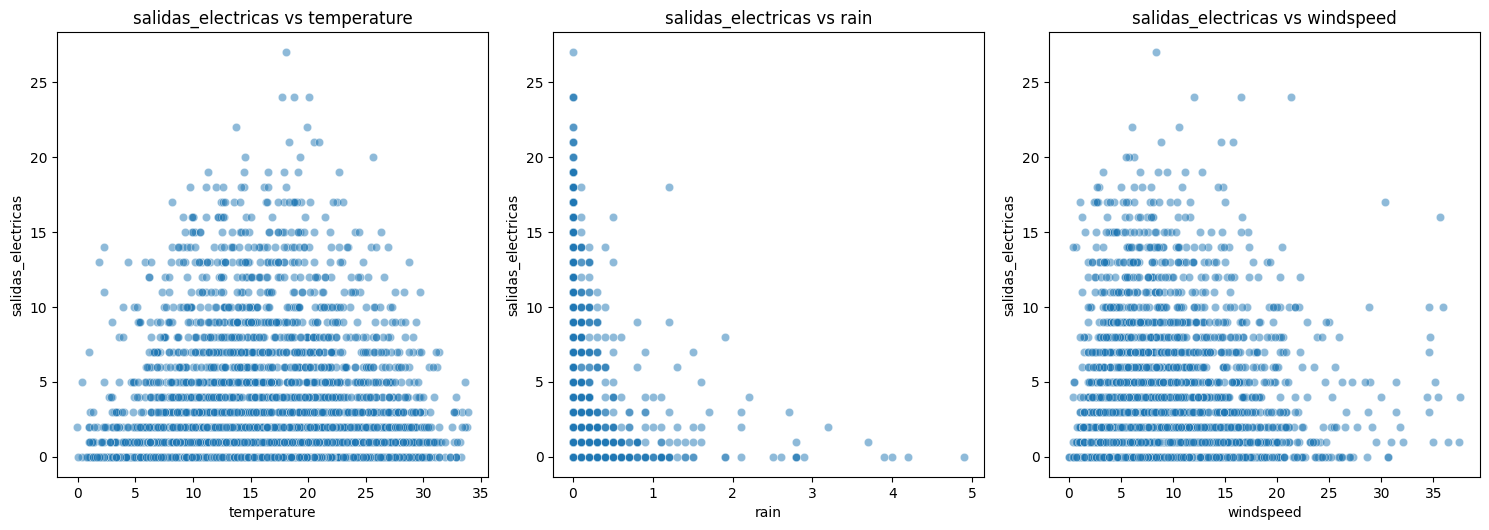

In [38]:
# Variables numéricas y categóricas seleccionadas
numeric_vars_selected = ["temperature", "rain", "windspeed"]
categorical_vars_selected = ["working_day", "day_week", "day_month", "month", "hour"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_selected, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=bicing, x=var, y="salidas_electricas", alpha=0.5)
    plt.title(f'salidas_electricas vs {var}')

plt.tight_layout()
plt.show()

Se aprecian tendencias naturales:
- La mayoría de salidas, se realizan cuando las temperaturas son moderadas.
- En el caso de la lluvia, es todavía más notorio que cuando no llueve o la lluvia es mínima, se cogen la mayoría de bicicletas.
- El viento no afecta tanto, pero sí que es cierto que cuando este alcanza velocidades considerables, el número de salidas cae bastante.

Vamos ahora a comparar el número de salidas con las variables categóricas `working_day`, `day_week`, `day_month`, `month`, `hour`:

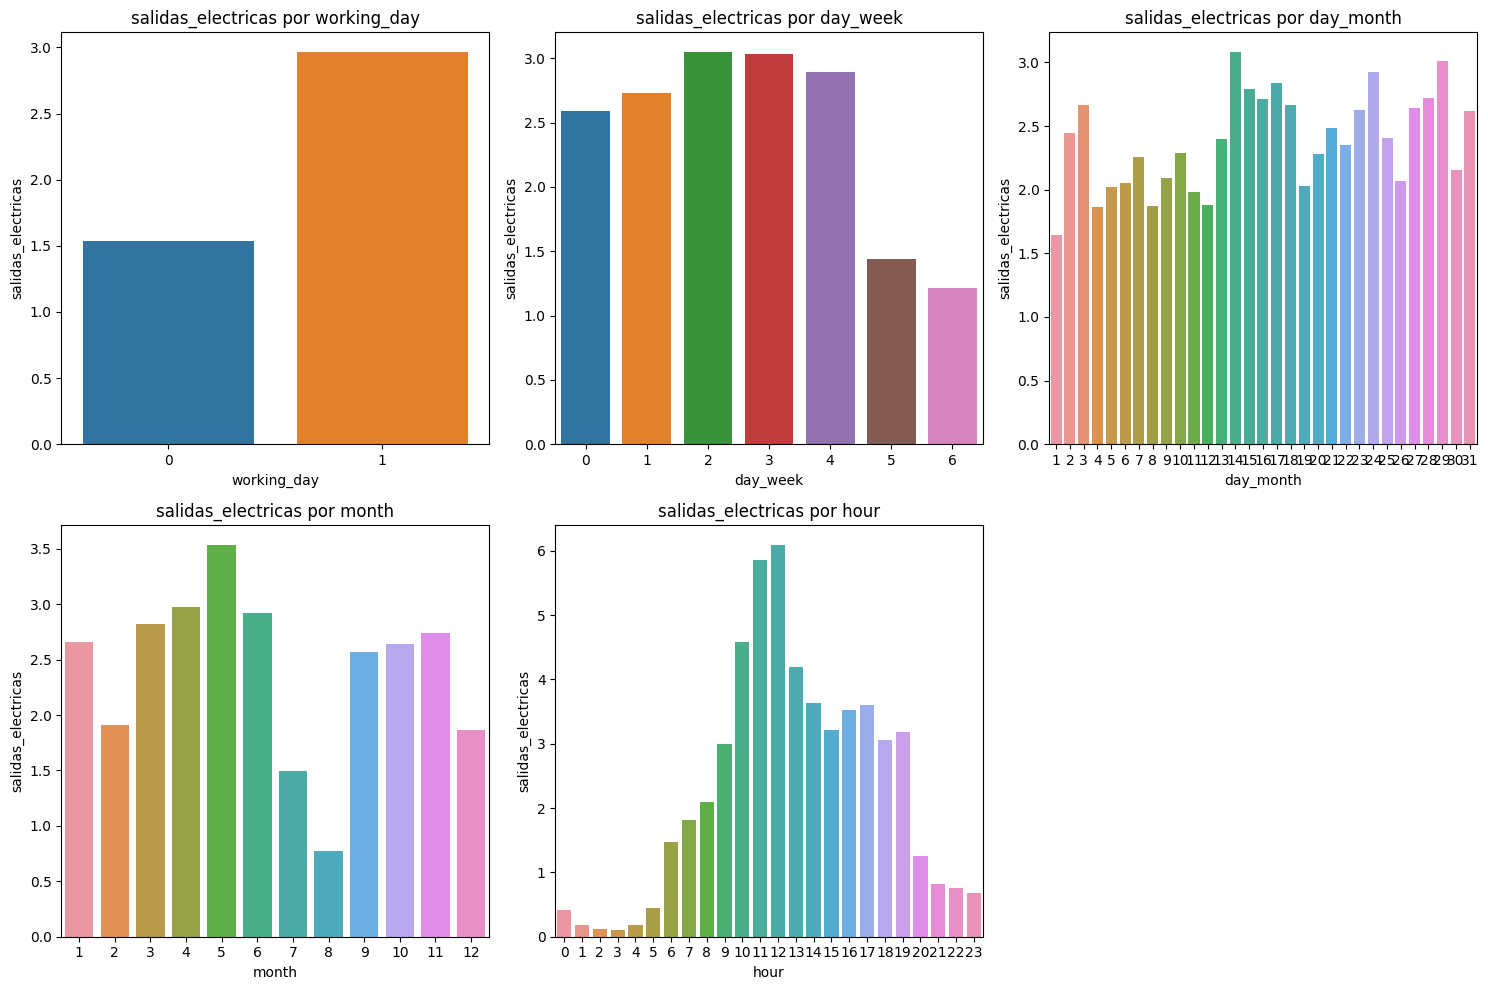

In [40]:
# Gráficos de barras para variables categóricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=bicing, x=var, y="salidas_electricas", errorbar=None) # ci=None para no mostrar el intervalo de confianza
    plt.title(f'salidas_electricas por {var}')

plt.tight_layout()
plt.show()

Aquí de nuevo extraemos conclusiones interesantes sobre variables que tienen una clara influencia sobre la variable objetivo:
- La cantidad de bicicletas eléctricas que se cogen en días laborables duplican a las que se cogen en días festivos.
- Existe un claro descenso de la salida de bicicletas durante el fin de semana.
- No se aprecian tendencias claras según el día del mes, ya que un mismo número de día puede caer en días de la semana distintos cada mes.
- Otro claro descenso es el que se produce en los meses de verano. Además también es notorio el repunte (seguramente motivado por el inicio del buen tiempo) en mayo.
- El uso por horas parece estar normalmente distribuido, produciendose el pico justo en las horas centrales.

A continuación, mostramos la mariz de correlación tal y como se pide en la documentación del proyecto. Sin embargo, no se aprecian correlaciones ya que las relaciones que hemos podido apreciar no son precisamente lineales.

In [41]:
# Calculando la matriz de correlación para las variables numéricas seleccionadas y la variable objetivo
correlation_matrix = bicing[["salidas_electricas"] + numeric_vars_selected].corr()

correlation_matrix

,salidas_electricas,temperature,rain,windspeed
salidas_electricas,1.000,0.062,-0.030,0.126
temperature,0.062,1.000,-0.021,0.024
rain,-0.030,-0.021,1.000,0.125
windspeed,0.126,0.024,0.125,1.000


## **Resultados de referencia con un modelo de regresión lineal**

A continuación utilizamos un modelo simple como es la regresión lineal para predecir la variable `salidas_electricas`. Utilizaremos el MSE como métrica para determinar si nuestr conjunto de datos es demasiado "simple", o sea, fácil de modelar (esto sería en caso de que sea muy bajo).

Realizaremos los siguientes pasos:
1. **Preprocesamiento de datos**: Para mantenerlo simple, normalizaremos las variables numéricas y codificaremos las variables categóricas.
2. **Escoger el modelo**: Usaremos la regresión lineal para predecir la variable "salidas_electricas" dado que es una variable continua.
3. **Evaluación**: Dividiremos el conjunto de datos en conjuntos de entrenamiento y prueba. Entrenaremos el modelo en el conjunto de entrenamiento y evaluaremos su rendimiento en el conjunto de prueba usando el error cuadrático medio (MSE) como métrica.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Dividir el conjunto de datos en entrenamiento y prueba
X = bicing[numeric_vars_selected + categorical_vars_selected]
y = bicing["salidas_electricas"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento: normalizar las variables numéricas y codificar las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_vars_selected),
        ('cat', OneHotEncoder(drop="first"), categorical_vars_selected)
    ])

# Crear y entrenar el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipeline.fit(X_train, y_train)

# Predecir y evaluar
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

mse

9.999631790829742

El error cuadrático medio (MSE) para el modelo de regresión lineal en el conjunto de prueba es aproximadamente

9.996

Esto sugiere que hay margen para mejorar y que modelos más sofisticados podrían ofrecer mejores predicciones.​​

Si tomamos la raiz cuadrada de este valor:

In [44]:
# Calculando el RMSE
rmse = np.sqrt(mse)
rmse

3.1622194406507815

Vemos que en promedio el modelo tiene un error de 3 bicicletas en la predicción. De nuevo, vemos que hay un margen de mejora que quizás podamos alcanzar con modelos más complejos.